# Loading CIFAR-10

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

In [2]:
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape  == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape  == (10000, 1)

y_train = np.squeeze(y_train)
y_test  = np.squeeze(y_test)

data_labels = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

170508288/170498071 [==============================] - 5s 0us/step


## Plotting some samples

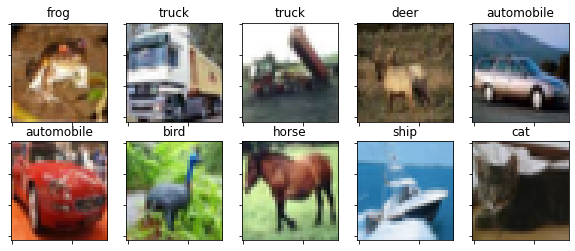

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,5, figsize=(10,4))

counter = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[counter], aspect='auto')
        ax[i,j].set_title(data_labels[y_train[counter]])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xticklabels([])
        counter += 1

## Counting labels

In [4]:
for i in data_labels.keys():
    print(f'{data_labels[i]} : {len(np.where(y_train==i)[0])}')

airplane : 5000
automobile : 5000
bird : 5000
cat : 5000
deer : 5000
dog : 5000
frog : 5000
horse : 5000
ship : 5000
truck : 5000


## Split validation

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

## Visualizations

In [8]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_history(history):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5),sharex=True)
    r = np.arange(len(history.history['loss']))+1
    ax[0].plot(r, history.history['loss'],label='Train')
    ax[0].plot(r, history.history['val_loss'],label='Validation')
    ax[0].set_ylabel('Loss Value')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(r, history.history['accuracy'],label='Train')
    ax[1].plot(r, history.history['val_accuracy'],label='Validation')
    ax[1].set_ylabel('Accuracy Value')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    ax[1].grid(True)
    #name = f'Model {model_type}_Run {run}_curves.pdf'
    plt.show()
    #fig.savefig(directory/name)
    plt.close(fig)    

def confusion(model, x_test, y_test):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    print (f'accuracy = {acc}')
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(cm_norm,index = data_labels.values(), columns = data_labels.values())

    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, annot=True,cmap="YlGnBu")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Test data confusion matrix')
    plt.show()

# MLP

## Data prepration

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pixels = 32*32*3

x_tr = np.reshape(x_train, (-1, pixels))
x_tr = scaler.fit_transform(x_tr)
x_va = np.reshape(x_valid, (-1, pixels))
x_va = scaler.transform(x_va)
x_te = np.reshape(x_test , (-1, pixels))
x_te = scaler.transform(x_te)

print(x_tr.shape, x_va.shape, x_te.shape)

(40000, 3072) (10000, 3072) (10000, 3072)


## MLP definition

In [10]:
from tensorflow.keras.layers import Dense, Dropout, Input, Softmax, Activation

def get_mlp(layers, dropout = 0.25, act = tf.nn.relu):
    model = keras.Sequential()
    model.add(Input(shape=(layers[0],)))
    
    depth = len(layers)-1
    for i in range(1, depth+1):
        model.add(Dense(units=layers[i], name=f'dense-{i}'))
        if i != depth:
            model.add(Activation(act, name=f'activation-{i}'))
            if dropout > 0:
                model.add(Dropout(rate=dropout))
        else:
            model.add(Softmax(axis=1, name='softmax'))
    return model

In [11]:
layers = [pixels, 500, 250, 10]
model  = get_mlp(layers, dropout=0.25)

# building the model using a dummy input
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model.predict(dummy) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense-1 (Dense)             (None, 500)               1536500   
                                                                 
 activation-1 (Activation)   (None, 500)               0         
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense-2 (Dense)             (None, 250)               125250    
                                                                 
 activation-2 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense-3 (Dense)             (None, 10)                2

## MLP training

In [21]:
lr = 0.05
bs = 200
ep = 300

er_stop = keras.callbacks.EarlyStopping(
    monitor= 'val_accuracy',patience=30,restore_best_weights=True
)

model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [13]:
hist = model.fit(
    x_tr, y_train,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_valid),
    verbose=2, callbacks = [er_stop]
)

Epoch 1/300
200/200 - 2s - loss: 1.8786 - accuracy: 0.3424 - val_loss: 1.6071 - val_accuracy: 0.4360 - 2s/epoch - 11ms/step
Epoch 2/300
200/200 - 1s - loss: 1.6418 - accuracy: 0.4188 - val_loss: 1.5281 - val_accuracy: 0.4667 - 1s/epoch - 7ms/step
Epoch 3/300
200/200 - 1s - loss: 1.5590 - accuracy: 0.4510 - val_loss: 1.4769 - val_accuracy: 0.4806 - 1s/epoch - 6ms/step
Epoch 4/300
200/200 - 1s - loss: 1.4955 - accuracy: 0.4726 - val_loss: 1.4468 - val_accuracy: 0.4935 - 1s/epoch - 5ms/step
Epoch 5/300
200/200 - 1s - loss: 1.4491 - accuracy: 0.4914 - val_loss: 1.4254 - val_accuracy: 0.5024 - 1s/epoch - 6ms/step
Epoch 6/300
200/200 - 1s - loss: 1.4094 - accuracy: 0.5030 - val_loss: 1.4034 - val_accuracy: 0.5101 - 1s/epoch - 5ms/step
Epoch 7/300
200/200 - 1s - loss: 1.3790 - accuracy: 0.5154 - val_loss: 1.3755 - val_accuracy: 0.5154 - 1s/epoch - 5ms/step
Epoch 8/300
200/200 - 1s - loss: 1.3419 - accuracy: 0.5274 - val_loss: 1.3673 - val_accuracy: 0.5191 - 1s/epoch - 6ms/step
Epoch 9/300
200

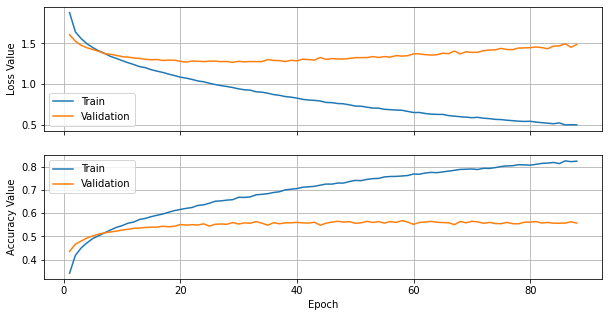

accuracy = 0.5523


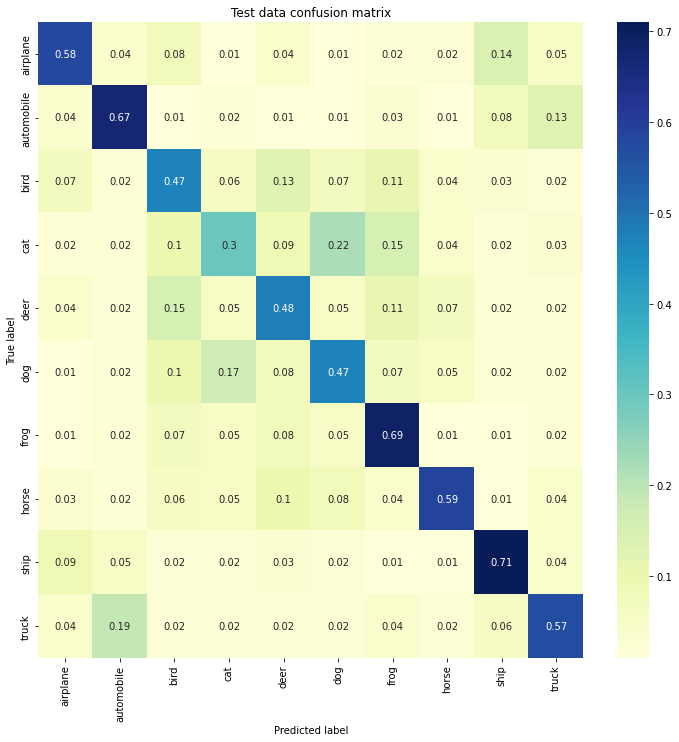

In [14]:
plot_history(hist)
confusion(model, x_te, y_test)

# 1A. Effect of batch size


## Timing functions

In [15]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

## BS = 64

Epoch 1/300
625/625 - 3s - loss: 1.8162 - accuracy: 0.3557 - val_loss: 1.6016 - val_accuracy: 0.4319 - 3s/epoch - 5ms/step
Epoch 2/300
625/625 - 3s - loss: 1.5993 - accuracy: 0.4344 - val_loss: 1.5147 - val_accuracy: 0.4668 - 3s/epoch - 4ms/step
Epoch 3/300
625/625 - 3s - loss: 1.5271 - accuracy: 0.4590 - val_loss: 1.4821 - val_accuracy: 0.4817 - 3s/epoch - 4ms/step
Epoch 4/300
625/625 - 3s - loss: 1.4642 - accuracy: 0.4805 - val_loss: 1.4316 - val_accuracy: 0.4913 - 3s/epoch - 4ms/step
Epoch 5/300
625/625 - 3s - loss: 1.4194 - accuracy: 0.4944 - val_loss: 1.4038 - val_accuracy: 0.5050 - 3s/epoch - 4ms/step
Epoch 6/300
625/625 - 3s - loss: 1.3844 - accuracy: 0.5110 - val_loss: 1.3834 - val_accuracy: 0.5124 - 3s/epoch - 4ms/step
Epoch 7/300
625/625 - 3s - loss: 1.3471 - accuracy: 0.5219 - val_loss: 1.3813 - val_accuracy: 0.5111 - 3s/epoch - 4ms/step
Epoch 8/300
625/625 - 3s - loss: 1.3133 - accuracy: 0.5328 - val_loss: 1.3565 - val_accuracy: 0.5197 - 3s/epoch - 4ms/step
Epoch 9/300
625/

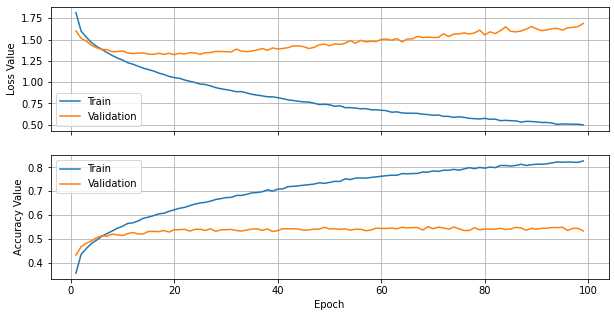

accuracy = 0.541


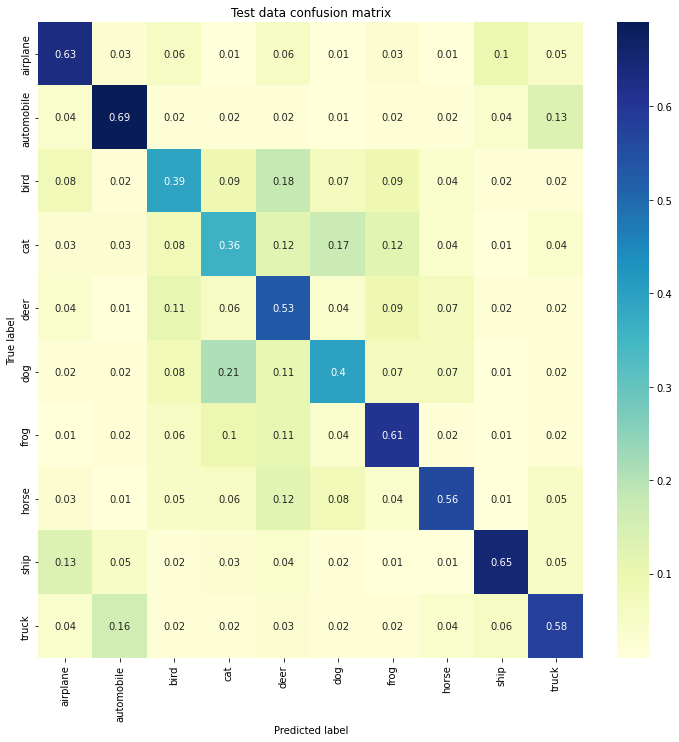

In [16]:
model1  = get_mlp(layers, dropout=0.25)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model1.predict(dummy)

bs = 64

model1.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist1 = model1.fit(
    x_tr, y_train,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_valid),
    verbose=2, callbacks = [er_stop]
)
toc()

plot_history(hist1)
confusion(model1, x_te, y_test)

## BS = 32

Epoch 1/300
1250/1250 - 5s - loss: 1.8305 - accuracy: 0.3531 - val_loss: 1.6196 - val_accuracy: 0.4274 - 5s/epoch - 4ms/step
Epoch 2/300
1250/1250 - 5s - loss: 1.6467 - accuracy: 0.4150 - val_loss: 1.5280 - val_accuracy: 0.4594 - 5s/epoch - 4ms/step
Epoch 3/300
1250/1250 - 4s - loss: 1.5782 - accuracy: 0.4392 - val_loss: 1.5251 - val_accuracy: 0.4547 - 4s/epoch - 4ms/step
Epoch 4/300
1250/1250 - 4s - loss: 1.5318 - accuracy: 0.4532 - val_loss: 1.4723 - val_accuracy: 0.4777 - 4s/epoch - 4ms/step
Epoch 5/300
1250/1250 - 4s - loss: 1.4908 - accuracy: 0.4710 - val_loss: 1.4809 - val_accuracy: 0.4752 - 4s/epoch - 4ms/step
Epoch 6/300
1250/1250 - 5s - loss: 1.4599 - accuracy: 0.4781 - val_loss: 1.4515 - val_accuracy: 0.4796 - 5s/epoch - 4ms/step
Epoch 7/300
1250/1250 - 5s - loss: 1.4290 - accuracy: 0.4924 - val_loss: 1.4435 - val_accuracy: 0.4869 - 5s/epoch - 4ms/step
Epoch 8/300
1250/1250 - 4s - loss: 1.3978 - accuracy: 0.5027 - val_loss: 1.4302 - val_accuracy: 0.4882 - 4s/epoch - 4ms/step


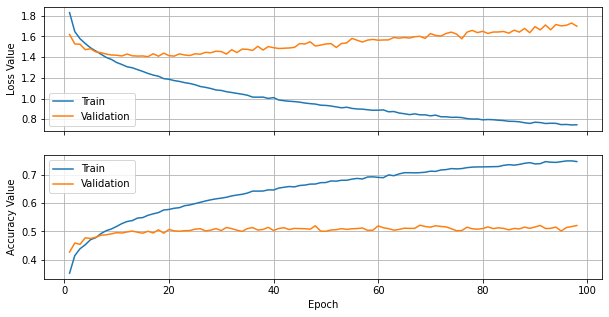

accuracy = 0.5108


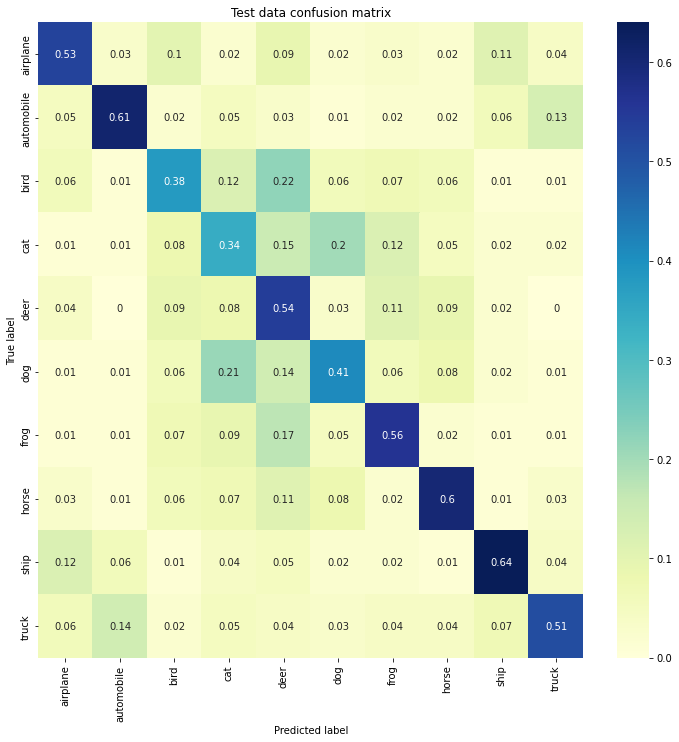

In [17]:
model2  = get_mlp(layers, dropout=0.25)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model2.predict(dummy)

bs = 32

model2.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist2 = model2.fit(
    x_tr, y_train,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_valid),
    verbose=2, callbacks = [er_stop]
)
toc()

plot_history(hist2)
confusion(model2, x_te, y_test)

## BS = 256

Epoch 1/300
157/157 - 2s - loss: 1.9032 - accuracy: 0.3320 - val_loss: 1.6337 - val_accuracy: 0.4289 - 2s/epoch - 12ms/step
Epoch 2/300
157/157 - 1s - loss: 1.6636 - accuracy: 0.4125 - val_loss: 1.5523 - val_accuracy: 0.4597 - 1s/epoch - 7ms/step
Epoch 3/300
157/157 - 1s - loss: 1.5760 - accuracy: 0.4453 - val_loss: 1.5136 - val_accuracy: 0.4708 - 1s/epoch - 8ms/step
Epoch 4/300
157/157 - 1s - loss: 1.5179 - accuracy: 0.4647 - val_loss: 1.4741 - val_accuracy: 0.4885 - 1s/epoch - 6ms/step
Epoch 5/300
157/157 - 1s - loss: 1.4695 - accuracy: 0.4830 - val_loss: 1.4542 - val_accuracy: 0.4886 - 1s/epoch - 7ms/step
Epoch 6/300
157/157 - 1s - loss: 1.4352 - accuracy: 0.4956 - val_loss: 1.4449 - val_accuracy: 0.4853 - 1s/epoch - 7ms/step
Epoch 7/300
157/157 - 1s - loss: 1.4019 - accuracy: 0.5072 - val_loss: 1.4146 - val_accuracy: 0.5033 - 1s/epoch - 7ms/step
Epoch 8/300
157/157 - 1s - loss: 1.3745 - accuracy: 0.5177 - val_loss: 1.3949 - val_accuracy: 0.5140 - 1s/epoch - 7ms/step
Epoch 9/300
157

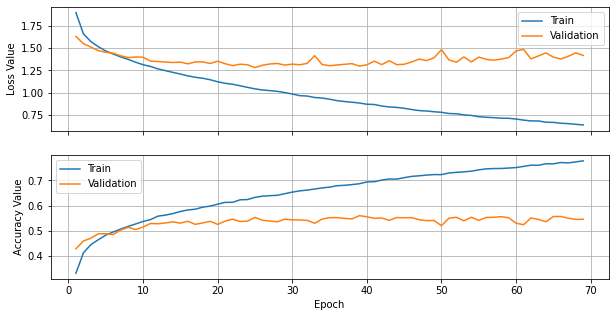

accuracy = 0.5458


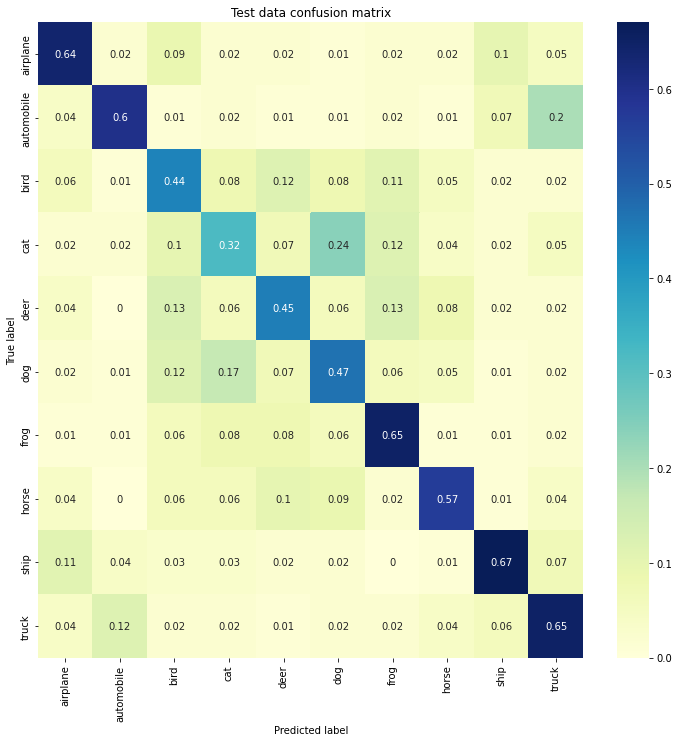

In [18]:
model3  = get_mlp(layers, dropout=0.25)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model3.predict(dummy)

bs = 256

model3.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist3 = model3.fit(
    x_tr, y_train,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_valid),
    verbose=2, callbacks = [er_stop]
)
toc()

plot_history(hist3)
confusion(model3, x_te, y_test)

# 1B. Effect of activation function
We have already used `ReLU`. Now we train a network using `tanh`. We use the best hyperparameters from previous section.

Epoch 1/300
157/157 - 2s - loss: 1.9515 - accuracy: 0.3230 - val_loss: 1.7565 - val_accuracy: 0.3901 - 2s/epoch - 10ms/step
Epoch 2/300
157/157 - 1s - loss: 1.7788 - accuracy: 0.3816 - val_loss: 1.7121 - val_accuracy: 0.4028 - 1s/epoch - 7ms/step
Epoch 3/300
157/157 - 1s - loss: 1.7079 - accuracy: 0.4060 - val_loss: 1.6519 - val_accuracy: 0.4297 - 1s/epoch - 7ms/step
Epoch 4/300
157/157 - 1s - loss: 1.6639 - accuracy: 0.4277 - val_loss: 1.6842 - val_accuracy: 0.4106 - 1s/epoch - 7ms/step
Epoch 5/300
157/157 - 1s - loss: 1.6302 - accuracy: 0.4349 - val_loss: 1.6292 - val_accuracy: 0.4394 - 1s/epoch - 7ms/step
Epoch 6/300
157/157 - 1s - loss: 1.6007 - accuracy: 0.4474 - val_loss: 1.6153 - val_accuracy: 0.4423 - 1s/epoch - 7ms/step
Epoch 7/300
157/157 - 1s - loss: 1.5782 - accuracy: 0.4565 - val_loss: 1.5958 - val_accuracy: 0.4499 - 1s/epoch - 7ms/step
Epoch 8/300
157/157 - 1s - loss: 1.5562 - accuracy: 0.4646 - val_loss: 1.5987 - val_accuracy: 0.4462 - 1s/epoch - 7ms/step
Epoch 9/300
157

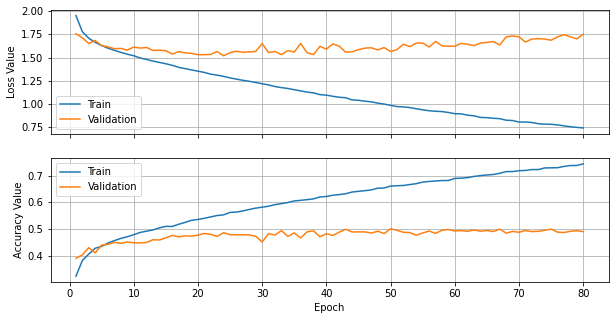

accuracy = 0.4914


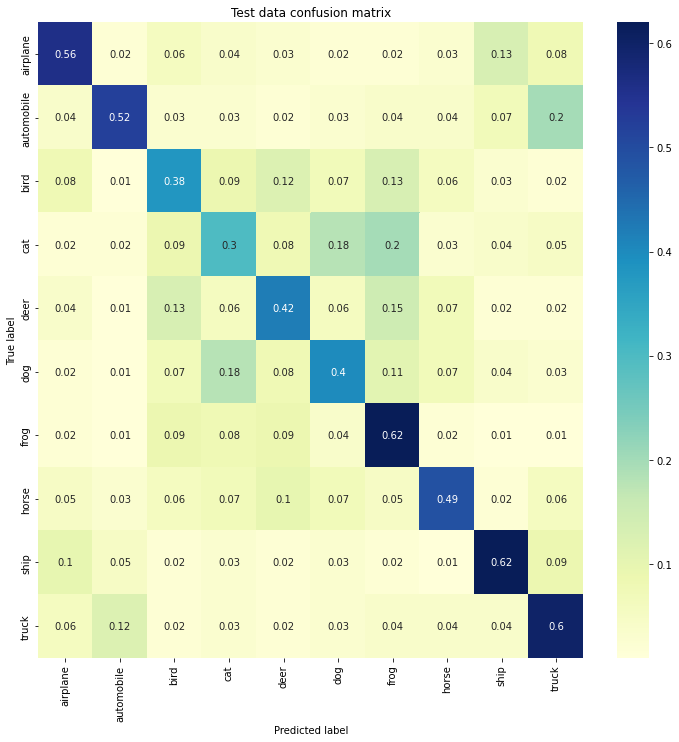

In [23]:
model4  = get_mlp(layers, dropout=0.25, act=tf.math.tanh)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model4.predict(dummy)

bs = 256

model4.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

tic()
hist4 = model4.fit(
    x_tr, y_train,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_valid),
    verbose=2, callbacks = [er_stop]
)
toc()

plot_history(hist4)
confusion(model4, x_te, y_test)

# 1C. Effect of loss function
We have already seen networks trained using `CrossEntropy`. Now we train network using `MSE` as loss function.

First we convert our labels to one-hot.

In [27]:
from tensorflow.keras.utils import to_categorical

y_tr_onehot = to_categorical(y_train)
y_va_onehot = to_categorical(y_valid)
y_te_onehot = to_categorical(y_test)

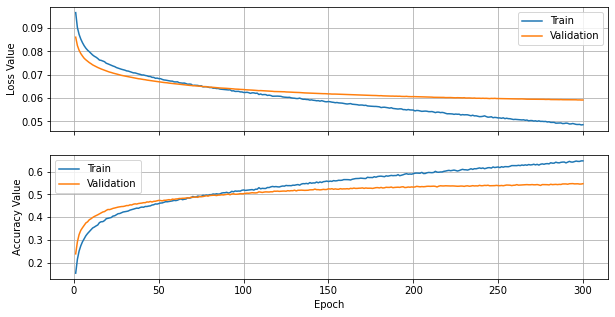

accuracy = 0.5406


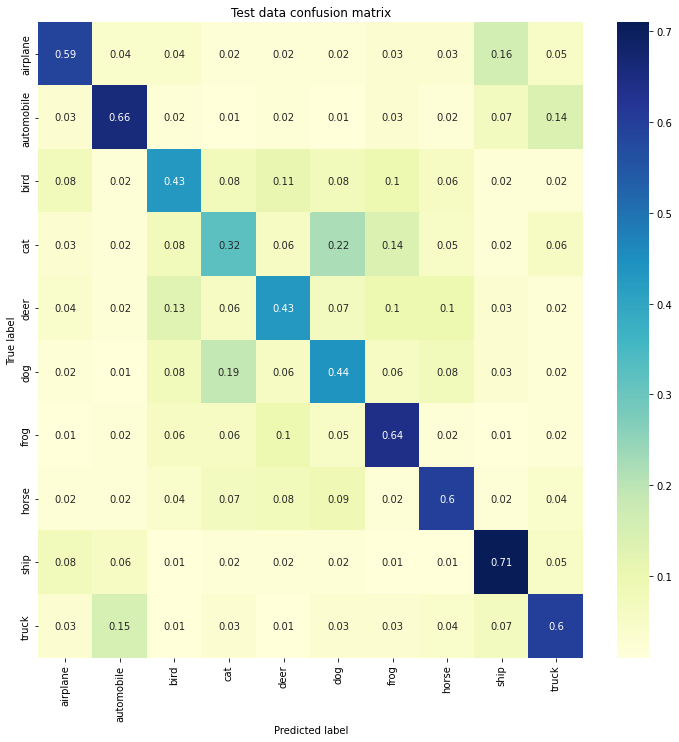

In [31]:
model5  = get_mlp(layers, dropout=0.25)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model5.predict(dummy)

bs = 256

model5.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.MeanSquaredError(),
    metrics = ['accuracy']
)

tic()
hist5 = model5.fit(
    x_tr, y_tr_onehot,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va_onehot),
    verbose=2, callbacks = [er_stop]
)
toc()

plot_history(hist5)
confusion(model5, x_te, y_test)

# 1D. Effect of Optimizer

Epoch 1/500
157/157 - 2s - loss: 0.0857 - accuracy: 0.3073 - val_loss: 0.0742 - val_accuracy: 0.3993 - 2s/epoch - 13ms/step
Epoch 2/500
157/157 - 1s - loss: 0.0747 - accuracy: 0.3906 - val_loss: 0.0706 - val_accuracy: 0.4270 - 1s/epoch - 7ms/step
Epoch 3/500
157/157 - 1s - loss: 0.0716 - accuracy: 0.4230 - val_loss: 0.0686 - val_accuracy: 0.4493 - 1s/epoch - 8ms/step
Epoch 4/500
157/157 - 1s - loss: 0.0697 - accuracy: 0.4399 - val_loss: 0.0674 - val_accuracy: 0.4634 - 1s/epoch - 7ms/step
Epoch 5/500
157/157 - 1s - loss: 0.0678 - accuracy: 0.4612 - val_loss: 0.0656 - val_accuracy: 0.4797 - 1s/epoch - 7ms/step
Epoch 6/500
157/157 - 1s - loss: 0.0666 - accuracy: 0.4699 - val_loss: 0.0656 - val_accuracy: 0.4843 - 1s/epoch - 7ms/step
Epoch 7/500
157/157 - 1s - loss: 0.0654 - accuracy: 0.4841 - val_loss: 0.0654 - val_accuracy: 0.4834 - 1s/epoch - 8ms/step
Epoch 8/500
157/157 - 1s - loss: 0.0644 - accuracy: 0.4942 - val_loss: 0.0643 - val_accuracy: 0.4930 - 1s/epoch - 8ms/step
Epoch 9/500
157

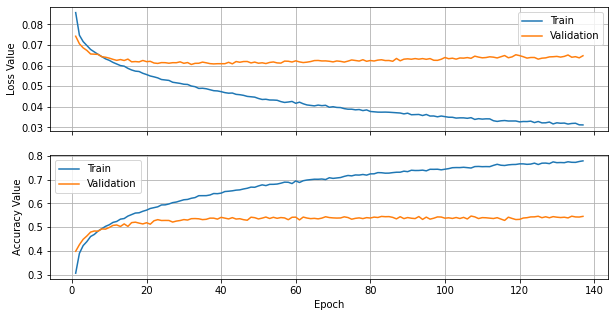

accuracy = 0.5411


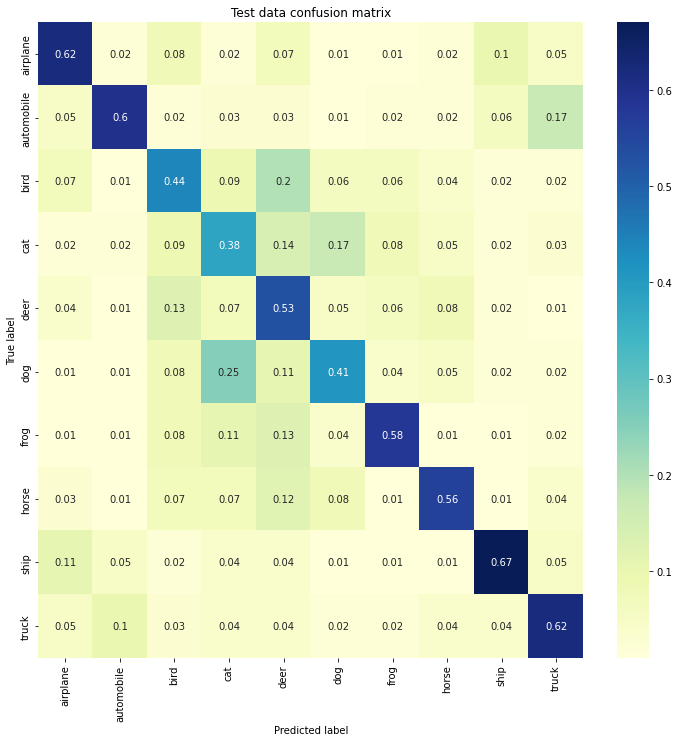

In [32]:
model6  = get_mlp(layers, dropout=0.25)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model6.predict(dummy)

bs = 256
ep = 500
lr = 0.001

model6.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
    loss = keras.losses.MeanSquaredError(),
    metrics = ['accuracy']
)

tic()
hist6 = model6.fit(
    x_tr, y_tr_onehot,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va_onehot),
    verbose=2, callbacks = [er_stop]
)
toc()

plot_history(hist6)
confusion(model6, x_te, y_test)

# 1E. Other metrics

In [35]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model6.predict(x_te), axis=1)
print (classification_report(y_test, y_pred, target_names=list(data_labels.values())))

              precision    recall  f1-score   support

    airplane       0.62      0.62      0.62      1000
  automobile       0.72      0.60      0.65      1000
        bird       0.42      0.44      0.43      1000
         cat       0.34      0.38      0.36      1000
        deer       0.38      0.53      0.44      1000
         dog       0.48      0.41      0.44      1000
        frog       0.65      0.58      0.61      1000
       horse       0.65      0.56      0.60      1000
        ship       0.70      0.67      0.68      1000
       truck       0.60      0.62      0.61      1000

    accuracy                           0.54     10000
   macro avg       0.56      0.54      0.55     10000
weighted avg       0.56      0.54      0.55     10000



# 1F. Unbalanced dataset
If the number of samples in classes are not equal to each other, then we have an unbalanced dataset. This can bias our model to learn the prominent classes. To solve this problem, we can use **weight training**. We make greater updates using small-number classes.

# 1.G Train on unbalanced dataset

## Deleting some training samples

In [51]:
data_labels = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

def delete(x_train, y_train, classes=[0, 2], percent=0.5):
    x = np.copy(x_train)
    y = np.copy(y_train)
    for c in classes:
        I = np.where(y==c)[0] # indices
        N = len(I) # number of samples
        P = np.random.permutation(N) # Permute
        L = np.int32(np.floor(0.5*N)) # deletions
        d = I[P][:L]
        x = np.delete(x, d, axis=0)
        y = np.delete(y, d, axis=0)
    return x, y

In [58]:
x, y = delete(x_tr, y_train)
print ('*** class sizes after deleting ***')
for i in data_labels.keys():
    print(f'{data_labels[i]} : {len(np.where(y==i)[0])}')

*** class sizes after deleting ***
airplane : 2013
automobile : 3996
bird : 2007
cat : 3967
deer : 4009
dog : 4010
frog : 4005
horse : 3947
ship : 3985
truck : 4043


## Class weight definition

In [59]:
class_weight = dict()
for i in data_labels.keys():
    class_weight[i] = 1.0 - (len(np.where(y==i)[0]) / len(y))
print(class_weight)

{0: 0.9440553610138402, 1: 0.888944472236118, 2: 0.9442221110555278, 3: 0.8897504307709411, 4: 0.8885831804791284, 5: 0.8885553888055139, 6: 0.8886943471735868, 7: 0.8903062642432327, 8: 0.8892501806458785, 9: 0.8876382635762325}


## Train using class weights

Epoch 1/300
141/141 - 2s - loss: 0.0857 - accuracy: 0.1627 - val_loss: 0.0845 - val_accuracy: 0.2707 - 2s/epoch - 14ms/step
Epoch 2/300
141/141 - 1s - loss: 0.0779 - accuracy: 0.2559 - val_loss: 0.0810 - val_accuracy: 0.3218 - 1000ms/epoch - 7ms/step
Epoch 3/300
141/141 - 1s - loss: 0.0748 - accuracy: 0.2998 - val_loss: 0.0789 - val_accuracy: 0.3510 - 1s/epoch - 8ms/step
Epoch 4/300
141/141 - 1s - loss: 0.0726 - accuracy: 0.3263 - val_loss: 0.0773 - val_accuracy: 0.3698 - 1s/epoch - 7ms/step
Epoch 5/300
141/141 - 1s - loss: 0.0712 - accuracy: 0.3398 - val_loss: 0.0762 - val_accuracy: 0.3811 - 1s/epoch - 8ms/step
Epoch 6/300
141/141 - 1s - loss: 0.0699 - accuracy: 0.3608 - val_loss: 0.0753 - val_accuracy: 0.3906 - 1s/epoch - 8ms/step
Epoch 7/300
141/141 - 1s - loss: 0.0690 - accuracy: 0.3689 - val_loss: 0.0747 - val_accuracy: 0.3958 - 986ms/epoch - 7ms/step
Epoch 8/300
141/141 - 1s - loss: 0.0682 - accuracy: 0.3774 - val_loss: 0.0740 - val_accuracy: 0.4047 - 994ms/epoch - 7ms/step
Epoch

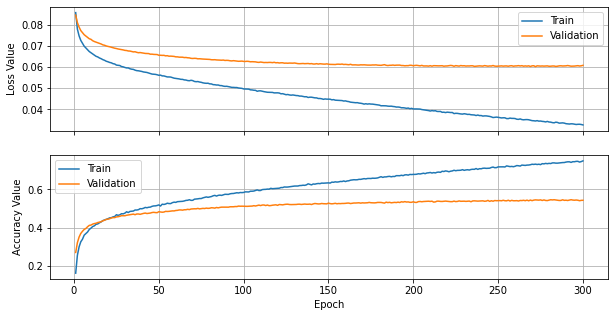

accuracy = 0.5318


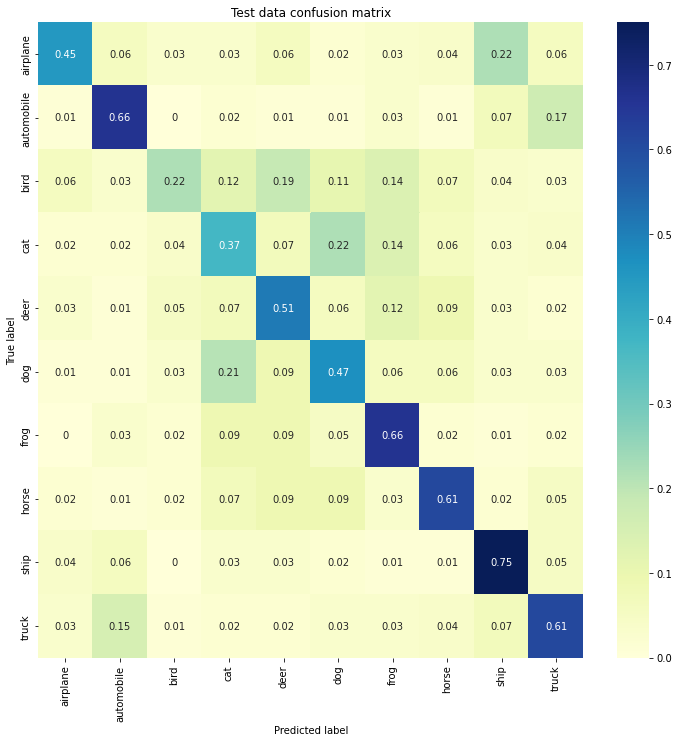

In [60]:
model7  = get_mlp(layers, dropout=0.25)
dummy = tf.random.normal(x_tr[0:2,:].shape)
_ = model7.predict(dummy)
y_onehot = to_categorical(y)

bs = 256
lr = 0.1
ep = 300

model7.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
    loss = keras.losses.MeanSquaredError(),
    metrics = ['accuracy']
)

tic()
hist7 = model7.fit(
    x, y_onehot,
    batch_size = bs, epochs = ep,
    validation_data = (x_va,y_va_onehot),
    class_weight = class_weight,
    verbose=2, callbacks = [er_stop]
)
toc()

plot_history(hist7)
confusion(model7, x_te, y_test)

In [61]:
y_pred = np.argmax(model7.predict(x_te), axis=1)
print (classification_report(y_test, y_pred, target_names=list(data_labels.values())))

              precision    recall  f1-score   support

    airplane       0.68      0.45      0.54      1000
  automobile       0.63      0.66      0.64      1000
        bird       0.53      0.23      0.32      1000
         cat       0.36      0.37      0.36      1000
        deer       0.44      0.51      0.47      1000
         dog       0.43      0.47      0.45      1000
        frog       0.53      0.66      0.59      1000
       horse       0.60      0.61      0.61      1000
        ship       0.60      0.75      0.66      1000
       truck       0.56      0.61      0.59      1000

    accuracy                           0.53     10000
   macro avg       0.54      0.53      0.52     10000
weighted avg       0.54      0.53      0.52     10000

